# 2025-11-14 Stiff Equations

* Implicit and explicit methods

* Stiff equations

* Adaptive time integrators

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

# Runge-Kutta table
struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

# Helper for stablity of RK methods
function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

# Some specific RK methods
rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)
heun = RKTable([0 0; 1 0], [.5, .5])
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)

# Solve an ODE with RK
function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

## Ordinary Differential Equations

Given initial conditions $y_0 = y \left( t = 0 \right)$, find $y \left( t \right)$ for $t > 0$ that satisfies

$$ y' = \dot{y} = \frac{\partial y}{\partial t} = f \left( t, y \right) $$

| **Application**    | $y$                           | $f$                       |
| ------------------ | ----------------------------- | ------------------------- |
| Orbital dynamics   | position, momentum            | conservation of momentum  |
| Chemical reactions | concentraction                | conservation of atoms     |
| Epidemiology       | infected/recovered population | transmission and recovery |

$y$ can be a scalar or a vector.

## Solving differential equations

### Linear equations

$$ y' = A \left( t \right) y + \text{source} \left( t \right) $$

Autonomous if $A \left( t \right) = A$ and the source term is independent of $t$.

If $y$ and $a = A$ are scalars, then $y \left( t \right) = e^{a t} y_0$.

If $y$ is a vector and $A$ is a matrix, then we have a similar solution for systems: $y \left( t \right) = e^{A t} y_0$.

### Matrix exponentation

What does it mean to exponentiate a matrix?
To the Taylor series!

$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \cdots $$

There exist many [practical ways to compute it](https://bpb-us-e1.wpmucdn.com/blogs.cornell.edu/dist/c/9924/files/2021/10/19ways.pdf).

Exploration:
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists.
Derive a finite expression for the matrix exponential using the scalar `exp` function.

## Forward Euler Method

The simplest method for solving $y' \left( t \right) = f \left( t, y \right)$ is to use a finite difference to write

$$ y' \approx \frac{y \left( h \right) - y \left( 0 \right)}{h} $$

which yields the solution estimate

$$ \tilde{y} \left( h \right) = y \left( 0 \right) + h f \left( 0, y \left( 0 \right) \right) $$

where $h$ is the step size.
Let's try this on a scalar problem

$$ y' = - k \left( y - \cos \left( t \right) \right) $$

where $k$ is a parameter controlling the rate at which the solution $u \left( t \right)$ is pulled toward the curve $\cos \left( t \right)$.

In [2]:
# Forward Euler ODE solver
function ode_euler(f, y0; tfinal=10., h=0.1)
    y = copy(y0)
    t = 0.
    thist = [t]
    yhist = [y0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        y += h * f(t, y)
        t = tnext
        push!(thist, t)
        push!(yhist, y)
    end
    thist, hcat(yhist...)
end

ode_euler (generic function with 1 method)

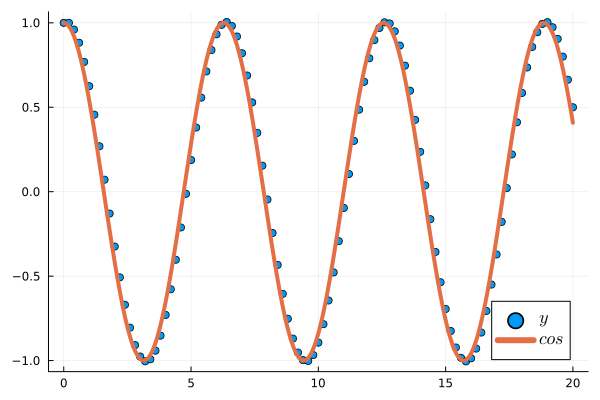

In [3]:
f1(t, y; k=10) = -k * (y .- cos(t))

thist, yhist = ode_euler(f1, [1.], tfinal=20, h=.2)
scatter(thist, yhist[1, :], marker=:circle, label="\$y\$")
plot!(cos, label="\$cos\$")

### Forward Euler for systems

Consider the linear system

$$ \begin{split}
  \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}' =
  \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix}
  \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}
\end{split} $$

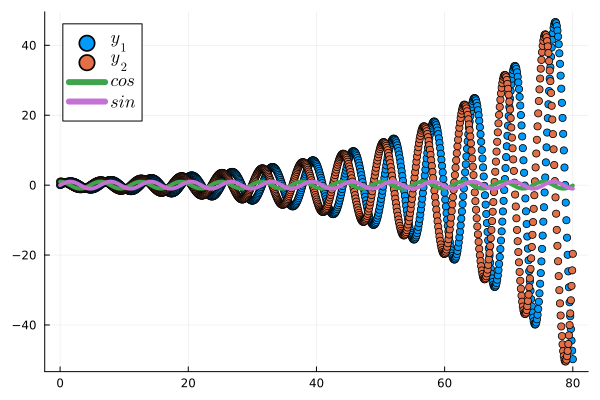

In [4]:
f2(t, y) = [0 1; -1 0] * y

thist, yhist = ode_euler(f2, [0., 1], h=.1, tfinal=80)
scatter(thist, yhist', label=["\$y_1\$" "\$y_2\$"])
plot!([cos, sin], label=["\$cos\$" "\$sin\$"])

In [5]:
# The eigevalues tell us why Euler struggles (below)
eigvals([0 1; -1 0])

2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im

## Runge-Kutta 4

We won't dive into the math here, but the [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) can be thought of as a weighted average of multiple finite differencing schemes.

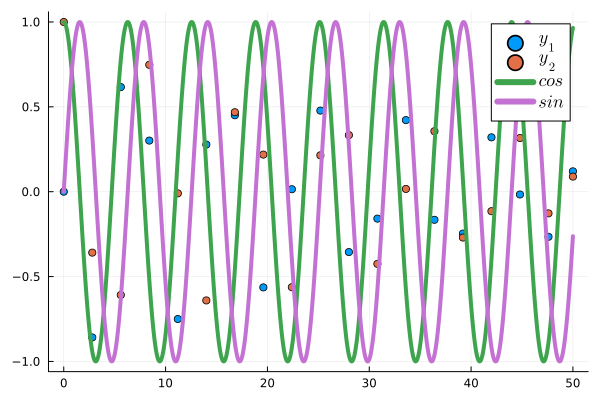

In [6]:
thist, yhist = ode_rk_explicit(f2, [0., 1], h=2.8, tfinal=50)
scatter(thist, yhist', label=["\$y_1\$" "\$y_2\$"])
plot!([cos, sin], label=["\$cos\$" "\$sin\$"])

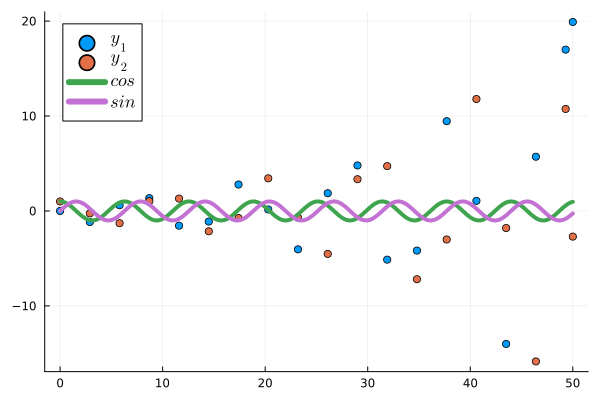

In [7]:
thist, yhist = ode_rk_explicit(f2, [0., 1], h=2.9, tfinal=50)
scatter(thist, yhist', label=["\$y_1\$" "\$y_2\$"])
plot!([cos, sin], label=["\$cos\$" "\$sin\$"])

Runge-Kutta 4 appears to integrate this system with much large time steps.
This method evaluates $f \left( y \right)$ four times per step so the cost is about equal when the step size $h$ is 4x larger than for forward Euler.

## Linear stability analysis

Why did Euler diverge (even if slowly) while RK4 solved this problem accurately?
And why do both methods diverge if the step size is too large?
We can understand the convergence of methods by analyzing the test problem

$$ y' = \lambda y $$

for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps

$$ y \rightarrow y + h \lambda y = \underbrace{(1 + h \lambda)}_{R \left( h \lambda \right)} y $$

When does this map cause solutions to "blow up" and when is it stable?

In [8]:
function plot_stability(Rz, method; xlim=(-3, 2), ylim=(-1.5, 1.5))
    x = xlim[1]:.02:xlim[2]
    y = ylim[1]:.02:ylim[2]
    plot(title="Stability: $method", aspect_ratio=:equal, xlim=xlim, ylim=ylim)
    heatmap!(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2))
    contour!(x, y, (x, y) -> abs(Rz(x + 1im*y)), color=:black, linewidth=2, levels=[1.])
    plot!(x->0, color=:black, linewidth=1, label=:none)
    plot!([0, 0], [ylim...], color=:black, linewidth=1, label=:none)
end

plot_stability (generic function with 1 method)

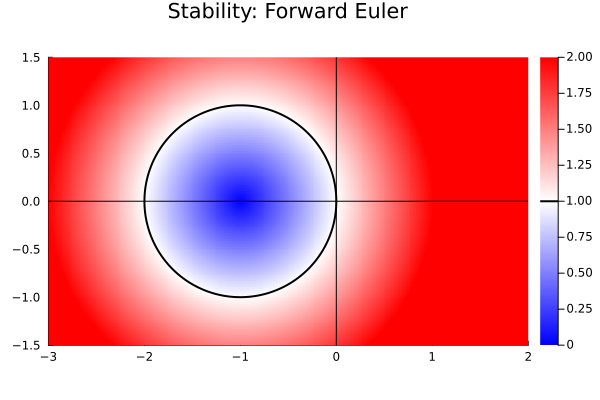

In [9]:
plot_stability(z -> 1 + z, "Forward Euler")

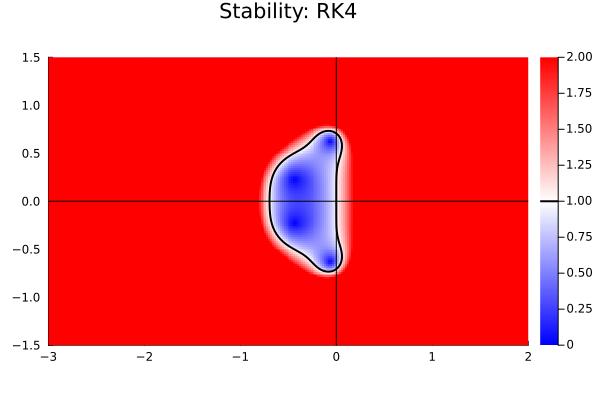

In [10]:
plot_stability(z -> rk_stability(4z, rk4), "RK4")

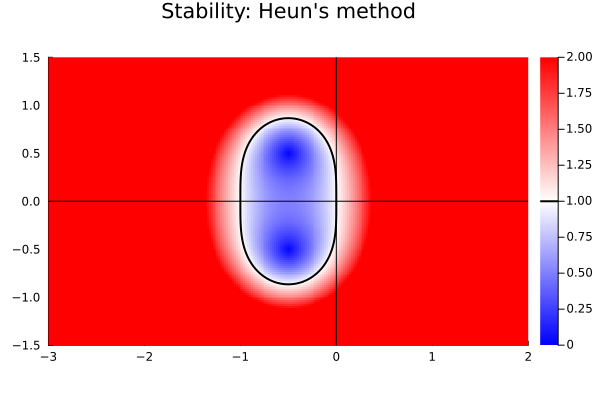

In [11]:
plot_stability(z -> rk_stability(2z, heun), "Heun's method")

## Implicit methods

Recall that forward Euler is the step

$$ \tilde{y} \left( h \right) = y \left( 0 \right) + h f \left( 0, y \left( 0 \right) \right) $$

This can be evaluated explicitly; all the terms on the right hand side are known so the approximation $\tilde{y} \left( h \right)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, backward Euler (or "implicit Euler"),

$$ \tilde{y} \left( h \right) = y \left( 0 \right) + h f \left( h, \tilde{y} \left( h \right) \right) $$

This is a (generally) nonlinear equation for $\tilde{y} \left( h \right)$.
For the test equation $y' = \lambda y$, the backward Euler method is

$$ \tilde{y} \left( h \right) + h \lambda \tilde{y} \left( h \right) $$

or

$$ \tilde y \left( h \right) = \underbrace{\frac{1}{1 - h \lambda}}_{R \left( h\lambda \right)} y(0) $$

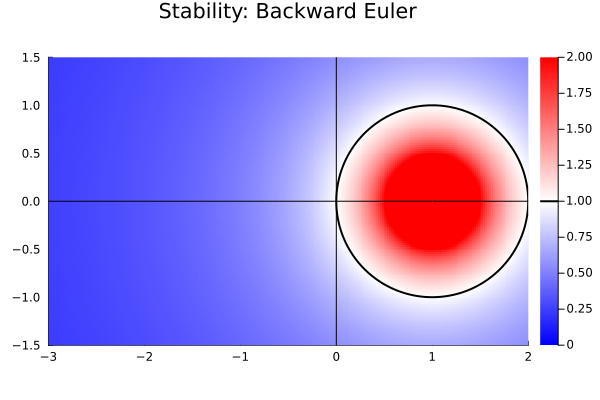

In [12]:
plot_stability(z -> 1/(1-z), "Backward Euler")

## Using implicit methods

$$ \tilde{y} \left( h \right) = y \left( 0 \right) + h f \left( \tilde{y} \left( h \right) \right) $$

We have a linear solve for the linear problem and a non-linear (often Newton) solve for the non-linear problem.
We need the Jacobian or finite differencing.

We can consider the midpoint method.

$$ \tilde{y} \left( h \right) = y \left( 0 \right) + h f \left( \frac{1}{2} y \left( 0 \right) + \tilde{y} \left( h \right) \right) $$

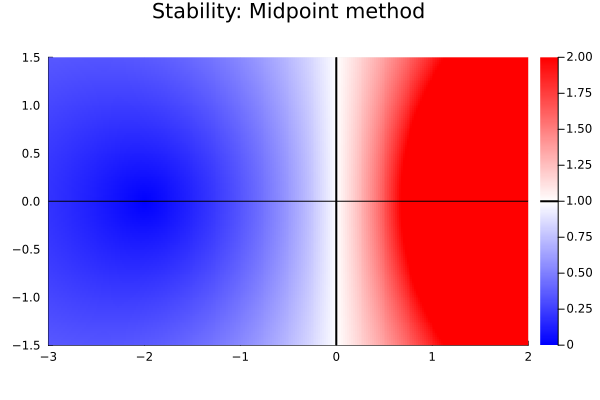

In [13]:
plot_stability(z -> Rz_theta(z, .5), "Midpoint method")

## The $\theta$ method

Forward and backward Euler and bookends of the family known as $\theta$ methods.

$$ \tilde{u} \left( h \right) = u \left( 0 \right) + h f \left( \theta h, \theta \tilde{u} \left( h \right) + \left( 1 - \theta \right) u \left( 0 \right) \right) $$

which, for linear problems, is solved as

$$ \left( I - h \theta A \right) u \left( h \right) = \left( I + h \left( 1 - \theta \right) A \right) u \left( 0 \right) 0 $$

$\theta = 0$ is explicit (forward) Euler, $\theta = 1$ in implicit (backward) Euler, and $\theta = 1 / 2$ are the midpoint or trapezoid rules (equivalent for linear problems).
The stability function is

$$  R \left( z \right) = \frac{1 + \left( 1 - \theta \right) z}{1 - \theta z} $$

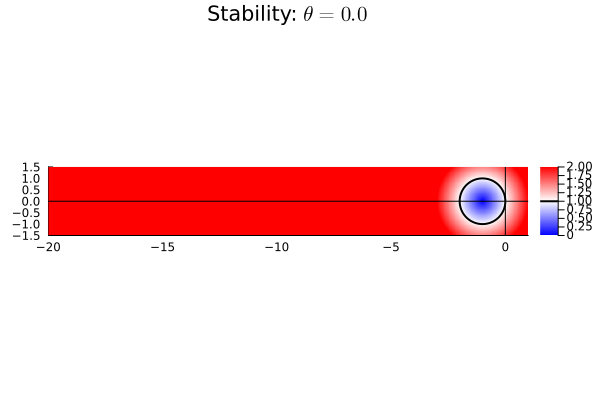

In [14]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta = 0.0
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$", xlim=(-20, 1))

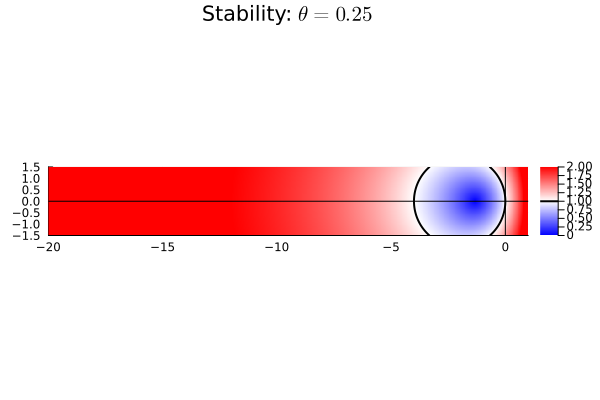

In [15]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta = 0.25
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$", xlim=(-20, 1))

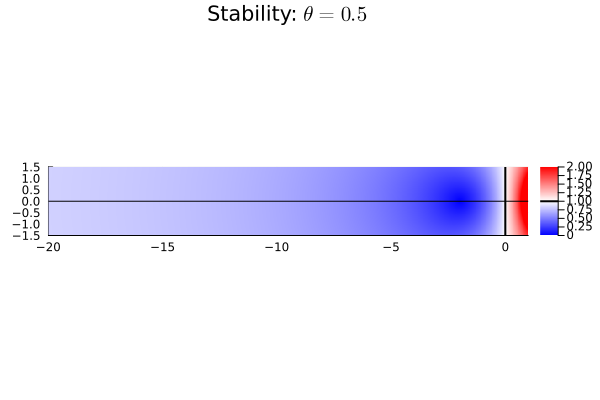

In [16]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta = 0.5
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$", xlim=(-20, 1))

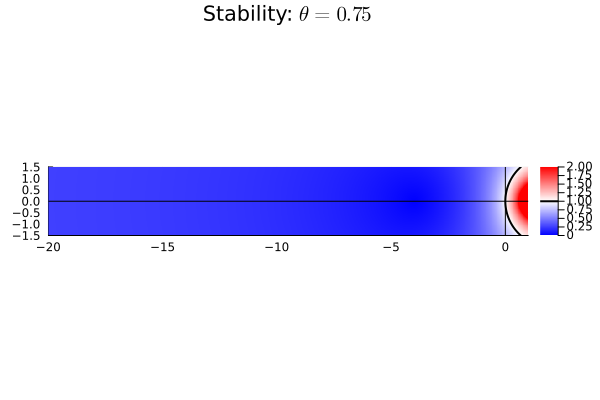

In [17]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta = 0.75
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$", xlim=(-20, 1))

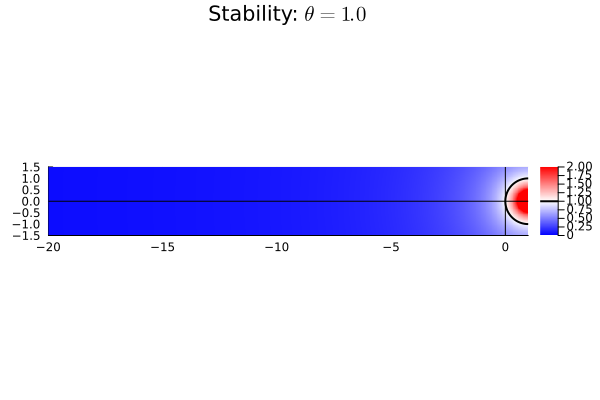

In [18]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta = 1.0
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$", xlim=(-20, 1))

## $\theta$ method for the oscillator

In [19]:
function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_theta_linear (generic function with 1 method)

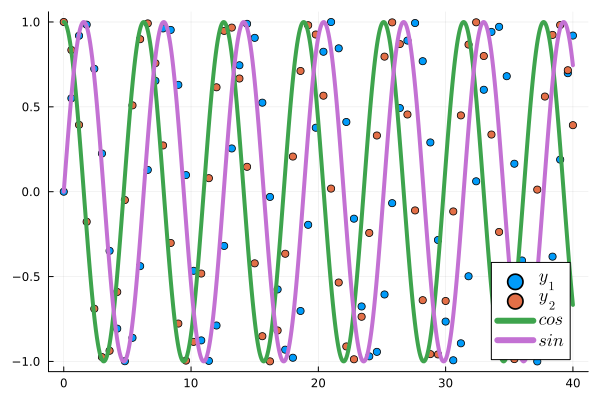

In [20]:
# Test on oscillator
A = [0 1; -1 0]
theta = 0.5
thist, uhist = ode_theta_linear(A, [0., 1], h=.6, theta=theta, tfinal=40)
scatter(thist, uhist', label=["\$y_1\$" "\$y_2\$"])
plot!([cos, sin], label=["\$cos\$" "\$sin\$"])

## $\theta$ method for the cosine decay

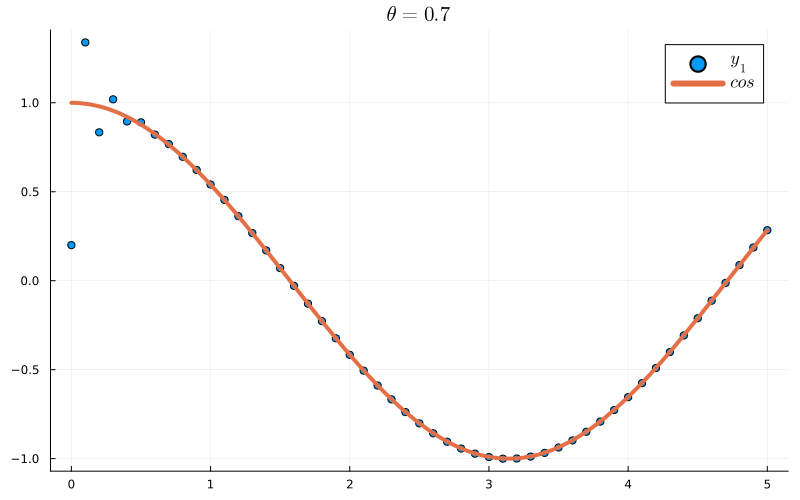

In [21]:
k = 500000
theta = 0.7
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.1, theta=theta)
scatter(thist, uhist[1,:], title="\$\\theta = $theta\$", label="\$y_1\$")
plot!(cos, size=(800, 500), label="\$cos\$")

## Stability classes and $\theta$ methods

### Definition: $A$-stability

A model is $A$-stable if the stability region

$$ \lbrace z : \lvert R \left( z \right) \rvert \leq 1 \rbrace $$

contains the entire left half plane

$$ \mathcal{R} \left[ z \right] \leq 0 $$

This means that the method can take arbitrarily large time steps without becoming unstable (diverging) for any problem that is physically stable.

### Definition: $L$-stability

A time integrator with stability function $R \left( z \right)$ is $L$-stable if

$$ \lim_{z \rightarrow \infty} R \left( z \right) = 0 $$

For the $\theta$ method, we have

$$ \lim_{z \rightarrow \infty} \frac{1 + \left( 1 - \theta \right) z}{1 - \theta z} = \frac{1 - \theta}{\theta} $$

Evidently only $\theta = 1$ is $L$-stable.

## Stiffness

> Stiff equations are problems for which explicit methods don't work. (Hairer and Wanner, 2002)

The term "stiff" dates to Curtiss and Hirschfelder (1952)

We'll use the cosine relaxation example $y_t = -k \left( y - \cos \left( t \right) \right)$ using the $\theta$ method, varying $k$ and $\theta$.

In [22]:
function ode_error(h; theta=.5, k=10)
    u0 = [.2]
    thist, uhist = ode_theta_linear(-k, u0, forcing=t -> k*cos(t), tfinal=3, h=h, theta=theta)
    T = thist[end]
    u_exact = (u0 .- k^2/(k^2+1)) * exp(-k*T) .+ k*(sin(T) + k*cos(T))/(k^2 + 1)
    uhist[1,end] .- u_exact
end

ode_error (generic function with 1 method)

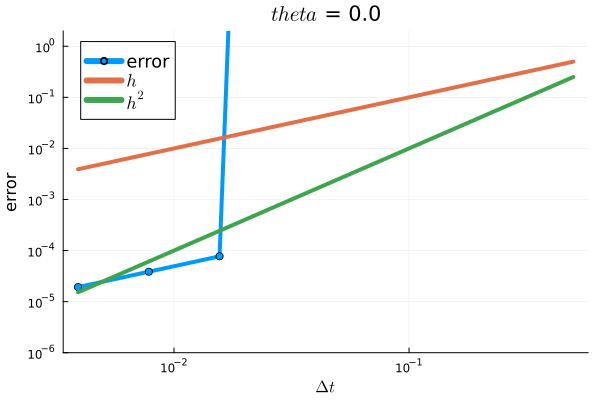

In [23]:
hs = .5 .^ (1:8)
θ = 0.0
errors = ode_error.(hs, theta=θ, k=100)
plot(hs, norm.(errors), marker=:circle, xscale=:log10, yscale=:log10, ylim=(1e-6, 2), label="error", title="\$theta\$ = $θ")
plot!(hs, hs, label="\$h\$", legend=:topleft)
plot!(hs, hs.^2, label="\$h^2\$", ylabel="error", xlabel="\$\\Delta t\$")

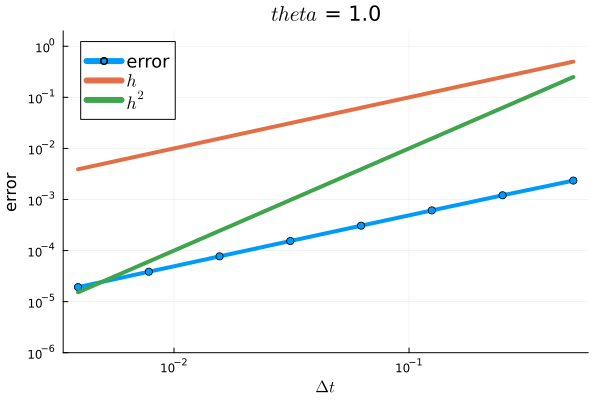

In [24]:
hs = .5 .^ (1:8)
θ = 1.0
errors = ode_error.(hs, theta=θ, k=100)
plot(hs, norm.(errors), marker=:circle, xscale=:log10, yscale=:log10, ylim=(1e-6, 2), label="error", title="\$theta\$ = $θ")
plot!(hs, hs, label="\$h\$", legend=:topleft)
plot!(hs, hs.^2, label="\$h^2\$", ylabel="error", xlabel="\$\\Delta t\$")

### Examples of stiff systems

Stiff problems posses multiple time scales and the fastest scale is "not interesting".

For example, the ocean.

Non-stiff problems are ones where there is only a single time scale or there are multiple and we are interested in the fastest time scale.

For example, the ocean.

## Adaptive time integrators

The [Oregonator](http://www.scholarpedia.org/article/Oregonator) mechanism in chemical kinetics describes an oscillatory chemical system.
It consists of three species with concentrations $\mathbf{x} = \left[ x_0, x_1, x_2 \right]^T$ (scaled units) and the evolution equations

$$ \begin{split}
\mathbf {x'} = \begin{bmatrix}
    77.27 \big(x_1 + x_0 (1 - 8.375\cdot 10^{-6} x_0 - x_1) \big) \\
    \frac{1}{77.27} \big(x_2 - (1 + x_0) x_1 \big) \\
    0.161 (x_0 - x_2)
\end{bmatrix}
\end{split} $$

We simulate from the initial conditions $\mathbf{x}_0 = \left[1, 2, 3 \right]^T$.

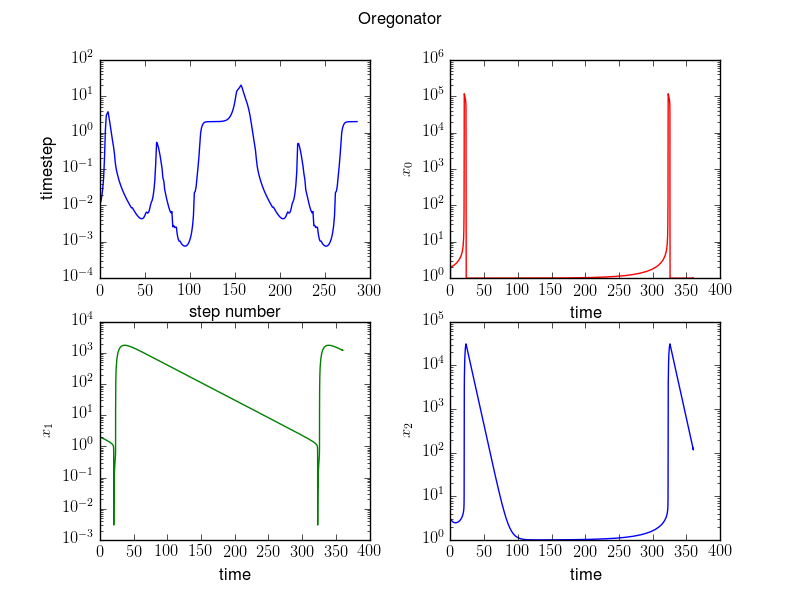